In [1]:
# !pip install scikit-fuzzy


### Importacion de librerías

In [2]:
import sim
import time
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

### Creacion de clases

### Clases correspondientes a las trayectorias

In [ ]:
class TrayectoriaGeometrica:

    def __init__(self, precision):
        self.precision = precision

    def lineal(self, x0, y0, x1, y1):
        x = np.linspace(x0, x1, self.precision)
        y = np.linspace(y0, y1, self.precision)
        return np.column_stack((x, y))

    def circular(self, x, y, r):
        theta = np.linspace(0, 2 * np.pi, self.precision)
        px = x + r * np.cos(theta)
        py = y + r * np.sin(theta)
        return np.column_stack((px, py))

    def rectangular(self, x0, y0, x1, y1):
        puntos = []

        # Lado inferior
        xi = np.linspace(x0, x1, self.precision, endpoint=False)
        yi = np.full_like(xi, y0)
        puntos.append(np.column_stack((xi, yi)))

        # Lado derecho
        yi = np.linspace(y0, y1, self.precision, endpoint=False)
        xi = np.full_like(yi, x1)
        puntos.append(np.column_stack((xi, yi)))

        # Lado superior
        xi = np.linspace(x1, x0, self.precision, endpoint=False)
        yi = np.full_like(xi, y1)
        puntos.append(np.column_stack((xi, yi)))

        # Lado izquierdo
        yi = np.linspace(y1, y0, self.precision)
        xi = np.full_like(yi, x0)
        puntos.append(np.column_stack((xi, yi)))

        return np.vstack(puntos)


### Conexion con copelia


In [4]:
def connect_to_coppelia():
    """Establece conexión con CoppeliaSim"""
    sim.simxFinish(-1)  # Cierra conexiones previas
    client_id = sim.simxStart('127.0.0.1', 19997, True, True, 5000, 5)
    if client_id != -1:
        print("✅ Conectado a CoppeliaSim")
    else:
        raise Exception("❌ No se pudo conectar")
    return client_id

def get_handles(client_id):
    """Obtiene los handles de los objetos del robot"""
    _, left_motor = sim.simxGetObjectHandle(client_id, 'Pioneer_p3dx_leftMotor', sim.simx_opmode_blocking)
    _, right_motor = sim.simxGetObjectHandle(client_id, 'Pioneer_p3dx_rightMotor', sim.simx_opmode_blocking)
    _, robot = sim.simxGetObjectHandle(client_id, 'Pioneer_p3dx', sim.simx_opmode_blocking)
    return left_motor, right_motor, robot

def get_robot_position(client_id, handle):
    """Obtiene posición y orientación del robot"""
    _, position = sim.simxGetObjectPosition(client_id, handle, -1, sim.simx_opmode_buffer)
    _, orientation = sim.simxGetObjectOrientation(client_id, handle, -1, sim.simx_opmode_buffer)
    return position, orientation

def set_motor_speeds(client_id, left_motor, right_motor, v_l, v_r):
    """Establece velocidades de los motores"""
    sim.simxSetJointTargetVelocity(client_id, left_motor, v_l, sim.simx_opmode_oneshot)
    sim.simxSetJointTargetVelocity(client_id, right_motor, v_r, sim.simx_opmode_oneshot)


In [5]:
def trayectoria(L, A, velTrayectoria):
    """Genera trayectoria cuadrada"""
    NptosLargo = round(L / (velTrayectoria * 0.1))
    NptosAncho = round(A / (velTrayectoria * 0.1))
    compx1 = np.linspace(0, L, NptosLargo)
    compy1 = np.linspace(0, A, NptosAncho)
    inx = compx1[1] - compx1[0]
    iny = compy1[1] - compy1[0]
    x1 = np.linspace(0, L - inx, NptosLargo)
    y1 = np.zeros_like(x1)
    y2 = np.linspace(iny, A - iny, NptosAncho)
    x2 = L * np.ones_like(y2)
    x3 = np.linspace(L - inx, inx, NptosLargo)
    y3 = A * np.ones_like(x3)
    y4 = np.linspace(A - iny, 0, NptosAncho)
    x4 = np.zeros_like(y4)
    xref = np.concatenate([x1, x2, x3, x4])
    yref = np.concatenate([y1, y2, y3, y4])
    return xref, yref


def trayectoria_circular(radio, velTrayectoria, cx=None, cy=None):
    """
    Genera trayectoria circular siguiendo el mismo estilo que trayectoria()
    
    Args:
        radio: Radio del círculo [m]
        velTrayectoria: Velocidad de la trayectoria [m/s]
        cx, cy: Centro del círculo [m] (por defecto: centro en radio, radio)
    
    Returns:
        xref, yref: Arrays de coordenadas de la trayectoria circular
    """
    # Si no se especifica centro, usar el radio como centro (círculo en primer cuadrante)
    if cx is None:
        cx = radio
    if cy is None:
        cy = radio
    
    # Calcular circunferencia total
    circunferencia = 2 * np.pi * radio
    
    # Número de puntos basado en velocidad (similar a la función original)
    Nptos = round(circunferencia / (velTrayectoria * 0.1))
    
    # Asegurar un mínimo de puntos para un círculo suave
    if Nptos < 20:
        Nptos = 20
    
    # Generar ángulos desde 0 hasta 2π
    angulos = np.linspace(0, 2*np.pi, Nptos)
    
    # Calcular coordenadas del círculo
    xref = cx + radio * np.cos(angulos)
    yref = cy + radio * np.sin(angulos)
    
    return xref, yref


def trayectoria_lineal(x0, y0, x1, y1, velTrayectoria):
    """
    Genera trayectoria lineal entre dos puntos siguiendo el mismo estilo que trayectoria()
    
    Args:
        x0, y0: Punto inicial [m]
        x1, y1: Punto final [m]
        velTrayectoria: Velocidad de la trayectoria [m/s]
    
    Returns:
        xref, yref: Arrays de coordenadas de la trayectoria lineal
    """
    # Calcular distancia entre puntos
    distancia = np.sqrt((x1 - x0)**2 + (y1 - y0)**2)
    
    # Número de puntos basado en velocidad (similar a la función original)
    Nptos = round(distancia / (velTrayectoria * 0.1))
    
    # Asegurar al menos 2 puntos
    if Nptos < 2:
        Nptos = 2
    
    # Generar coordenadas lineales
    xref = np.linspace(x0, x1, Nptos)
    yref = np.linspace(y0, y1, Nptos)
    
    return xref, yref


def normalize_angle(angle):
    """Normaliza ángulo entre -π y π"""
    return np.arctan2(np.sin(angle), np.cos(angle))




### Funcion para ver los graficos

In [6]:
def plot_results(trajectory_data, xref, yref):
    """Genera gráficos de análisis del seguimiento"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Gráfico 1: Trayectoria en el plano XY
    ax1.plot(xref, yref, 'b--', linewidth=2, label='Trayectoria de referencia')
    ax1.plot(trajectory_data['x_actual'], trajectory_data['y_actual'], 'r-', linewidth=1.5, label='Trayectoria real')
    ax1.scatter(xref[0], yref[0], color='green', s=100, marker='o', label='Inicio')
    ax1.scatter(xref[-1], yref[-1], color='red', s=100, marker='s', label='Final')
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_title('Seguimiento de Trayectoria Cuadrada')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.axis('equal')
    
    # Gráfico 2: Error de distancia vs tiempo
    ax2.plot(trajectory_data['time'], trajectory_data['error_distance'], 'b-', linewidth=1.5)
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('Error de Distancia (m)')
    ax2.set_title('Error de Distancia vs Tiempo')
    ax2.grid(True, alpha=0.3)
    
    # Gráfico 3: Error de orientación vs tiempo
    ax3.plot(trajectory_data['time'], trajectory_data['error_orientation'], 'g-', linewidth=1.5)
    ax3.set_xlabel('Tiempo (s)')
    ax3.set_ylabel('Error de Orientación (rad)')
    ax3.set_title('Error de Orientación vs Tiempo')
    ax3.grid(True, alpha=0.3)
    
    # Gráfico 4: Posición X e Y vs tiempo
    ax4.plot(trajectory_data['time'], trajectory_data['x_ref'], 'b--', label='X referencia')
    ax4.plot(trajectory_data['time'], trajectory_data['x_actual'], 'b-', label='X real')
    ax4.plot(trajectory_data['time'], trajectory_data['y_ref'], 'r--', label='Y referencia')
    ax4.plot(trajectory_data['time'], trajectory_data['y_actual'], 'r-', label='Y real')
    ax4.set_xlabel('Tiempo (s)')
    ax4.set_ylabel('Posición (m)')
    ax4.set_title('Posición vs Tiempo')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calcular métricas de rendimiento
    error_medio = np.mean(trajectory_data['error_distance'])
    error_max = np.max(trajectory_data['error_distance'])
    error_final = trajectory_data['error_distance'][-1]
    
    print("\n📊 Métricas de Rendimiento:")
    print(f"Error medio de distancia: {error_medio:.4f} m")
    print(f"Error máximo de distancia: {error_max:.4f} m")
    print(f"Error final de distancia: {error_final:.4f} m")


### Ejecucion principal

### controlador fuzzy

In [7]:
# CONTROLADOR FUZZY MEJORADO PARA SEGUIMIENTO DE TRAYECTORIA

def create_fuzzy_controller():
    """
    Controlador difuso MEJORADO para seguimiento robusto de trayectorias
    Con reglas optimizadas para transiciones suaves y completado de figura
    """
    
    # Rangos ajustados para mejor rendimiento
    max_distance = 3.0  # Rango ampliado para manejar errores grandes
    
    # Variables de entrada con mayor resolución
    angle_error = ctrl.Antecedent(np.linspace(-np.pi, np.pi, 201), 'angle_error')
    position_error = ctrl.Antecedent(np.linspace(0, max_distance, 151), 'position_error')
    
    # Variables de salida con rangos mejorados
    linear_speed = ctrl.Consequent(np.linspace(0, 0.25, 151), 'v')  # Velocidad máxima aumentada
    angular_speed = ctrl.Consequent(np.linspace(-3.0, 3.0, 151), 'w')  # Rango angular ampliado
    
    # Funciones de membresía MEJORADAS para ERROR ANGULAR (7 categorías)
    angle_error['muy_izq_extremo'] = fuzz.trapmf(angle_error.universe, [-np.pi, -np.pi, -5*np.pi/6, -2*np.pi/3])
    angle_error['izq_fuerte'] = fuzz.trimf(angle_error.universe, [-3*np.pi/4, -np.pi/2, -np.pi/4])
    angle_error['izq_suave'] = fuzz.trimf(angle_error.universe, [-np.pi/3, -np.pi/8, -np.pi/16])
    angle_error['centrado'] = fuzz.trimf(angle_error.universe, [-np.pi/12, 0, np.pi/12])
    angle_error['der_suave'] = fuzz.trimf(angle_error.universe, [np.pi/16, np.pi/8, np.pi/3])
    angle_error['der_fuerte'] = fuzz.trimf(angle_error.universe, [np.pi/4, np.pi/2, 3*np.pi/4])
    angle_error['muy_der_extremo'] = fuzz.trapmf(angle_error.universe, [2*np.pi/3, 5*np.pi/6, np.pi, np.pi])
    
    # Funciones de membresía MEJORADAS para ERROR DE POSICIÓN (5 categorías)
    position_error['muy_cerca'] = fuzz.trimf(position_error.universe, [0, 0, 0.08])
    position_error['cerca'] = fuzz.trimf(position_error.universe, [0.05, 0.15, 0.35])
    position_error['medio'] = fuzz.trimf(position_error.universe, [0.25, 0.6, 1.0])
    position_error['lejos'] = fuzz.trimf(position_error.universe, [0.8, 1.5, 2.2])
    position_error['muy_lejos'] = fuzz.trapmf(position_error.universe, [2.0, 2.5, max_distance, max_distance])
    
    # Funciones de membresía MEJORADAS para VELOCIDAD LINEAL (6 categorías)
    linear_speed['parado'] = fuzz.trimf(linear_speed.universe, [0, 0, 0.02])
    linear_speed['muy_lenta'] = fuzz.trimf(linear_speed.universe, [0.01, 0.04, 0.07])
    linear_speed['lenta'] = fuzz.trimf(linear_speed.universe, [0.05, 0.08, 0.12])
    linear_speed['media'] = fuzz.trimf(linear_speed.universe, [0.10, 0.15, 0.20])
    linear_speed['rapida'] = fuzz.trimf(linear_speed.universe, [0.18, 0.22, 0.25])
    linear_speed['muy_rapida'] = fuzz.trimf(linear_speed.universe, [0.23, 0.25, 0.25])
    
    # Funciones de membresía MEJORADAS para VELOCIDAD ANGULAR (7 categorías)
    angular_speed['giro_izq_extremo'] = fuzz.trimf(angular_speed.universe, [-3.0, -2.5, -1.8])
    angular_speed['giro_izq_fuerte'] = fuzz.trimf(angular_speed.universe, [-2.2, -1.5, -0.8])
    angular_speed['giro_izq_suave'] = fuzz.trimf(angular_speed.universe, [-1.0, -0.4, -0.1])
    angular_speed['recto'] = fuzz.trimf(angular_speed.universe, [-0.15, 0, 0.15])
    angular_speed['giro_der_suave'] = fuzz.trimf(angular_speed.universe, [0.1, 0.4, 1.0])
    angular_speed['giro_der_fuerte'] = fuzz.trimf(angular_speed.universe, [0.8, 1.5, 2.2])
    angular_speed['giro_der_extremo'] = fuzz.trimf(angular_speed.universe, [1.8, 2.5, 3.0])
    
    # REGLAS OPTIMIZADAS PARA SEGUIMIENTO ROBUSTO (24 reglas)
    rules = [
        # === CASOS EXTREMOS (errores muy grandes) ===
        ctrl.Rule(angle_error['muy_izq_extremo'] & position_error['muy_lejos'], 
                 (linear_speed['lenta'], angular_speed['giro_izq_extremo'])),
        ctrl.Rule(angle_error['muy_der_extremo'] & position_error['muy_lejos'], 
                 (linear_speed['lenta'], angular_speed['giro_der_extremo'])),
        
        # === CORRECCIÓN FUERTE (esquinas y cambios bruscos) ===
        ctrl.Rule(angle_error['izq_fuerte'] & position_error['muy_lejos'], 
                 (linear_speed['media'], angular_speed['giro_izq_fuerte'])),
        ctrl.Rule(angle_error['der_fuerte'] & position_error['muy_lejos'], 
                 (linear_speed['media'], angular_speed['giro_der_fuerte'])),
        ctrl.Rule(angle_error['izq_fuerte'] & position_error['lejos'], 
                 (linear_speed['lenta'], angular_speed['giro_izq_fuerte'])),
        ctrl.Rule(angle_error['der_fuerte'] & position_error['lejos'], 
                 (linear_speed['lenta'], angular_speed['giro_der_fuerte'])),
        
        # === CORRECCIÓN MODERADA ===
        ctrl.Rule(angle_error['izq_suave'] & position_error['muy_lejos'], 
                 (linear_speed['rapida'], angular_speed['giro_izq_suave'])),
        ctrl.Rule(angle_error['der_suave'] & position_error['muy_lejos'], 
                 (linear_speed['rapida'], angular_speed['giro_der_suave'])),
        ctrl.Rule(angle_error['izq_suave'] & position_error['lejos'], 
                 (linear_speed['media'], angular_speed['giro_izq_suave'])),
        ctrl.Rule(angle_error['der_suave'] & position_error['lejos'], 
                 (linear_speed['media'], angular_speed['giro_der_suave'])),
        ctrl.Rule(angle_error['izq_suave'] & position_error['medio'], 
                 (linear_speed['lenta'], angular_speed['giro_izq_suave'])),
        ctrl.Rule(angle_error['der_suave'] & position_error['medio'], 
                 (linear_speed['lenta'], angular_speed['giro_der_suave'])),
        
        # === NAVEGACIÓN DIRECTA (bien alineado) ===
        ctrl.Rule(angle_error['centrado'] & position_error['muy_lejos'], 
                 (linear_speed['muy_rapida'], angular_speed['recto'])),
        ctrl.Rule(angle_error['centrado'] & position_error['lejos'], 
                 (linear_speed['rapida'], angular_speed['recto'])),
        ctrl.Rule(angle_error['centrado'] & position_error['medio'], 
                 (linear_speed['media'], angular_speed['recto'])),
        ctrl.Rule(angle_error['centrado'] & position_error['cerca'], 
                 (linear_speed['lenta'], angular_speed['recto'])),
        ctrl.Rule(angle_error['centrado'] & position_error['muy_cerca'], 
                 (linear_speed['muy_lenta'], angular_speed['recto'])),
        
        # === SITUACIONES DE APROXIMACIÓN (cerca del objetivo) ===
        ctrl.Rule(angle_error['izq_suave'] & position_error['cerca'], 
                 (linear_speed['muy_lenta'], angular_speed['giro_izq_suave'])),
        ctrl.Rule(angle_error['der_suave'] & position_error['cerca'], 
                 (linear_speed['muy_lenta'], angular_speed['giro_der_suave'])),
        ctrl.Rule(angle_error['izq_fuerte'] & position_error['cerca'], 
                 (linear_speed['muy_lenta'], angular_speed['giro_izq_fuerte'])),
        ctrl.Rule(angle_error['der_fuerte'] & position_error['cerca'], 
                 (linear_speed['muy_lenta'], angular_speed['giro_der_fuerte'])),
        
        # === SITUACIONES CRÍTICAS (muy cerca) ===
        ctrl.Rule(position_error['muy_cerca'] & angle_error['izq_suave'], 
                 (linear_speed['muy_lenta'], angular_speed['giro_izq_suave'])),
        ctrl.Rule(position_error['muy_cerca'] & angle_error['der_suave'], 
                 (linear_speed['muy_lenta'], angular_speed['giro_der_suave'])),
        
        # === CASOS ESPECIALES (giros extremos cerca) ===
        ctrl.Rule(angle_error['muy_izq_extremo'] & position_error['cerca'], 
                 (linear_speed['parado'], angular_speed['giro_izq_extremo'])),
        ctrl.Rule(angle_error['muy_der_extremo'] & position_error['cerca'], 
                 (linear_speed['parado'], angular_speed['giro_der_extremo'])),
    ]
    
    # Crear el sistema de control
    fuzzy_ctrl = ctrl.ControlSystem(rules)
    fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_ctrl)
    
    print(f"🧠 Sistema de control difuso MEJORADO creado con {len(rules)} reglas")
    
    return fuzzy_sim

def fuzzy_controller(distance_error, orientation_error, fuzzy_sim):
    """
    Aplica el controlador difuso mejorado
    """
    try:
        # Limitar las entradas dentro de los rangos definidos
        distance_error = np.clip(distance_error, 0, 2.99)
        orientation_error = np.clip(orientation_error, -np.pi + 0.01, np.pi - 0.01)
        
        # Aplicar las entradas al sistema difuso
        fuzzy_sim.input['position_error'] = distance_error
        fuzzy_sim.input['angle_error'] = orientation_error
        
        # Computar el resultado
        fuzzy_sim.compute()
        
        # Obtener las salidas
        velocity_output = fuzzy_sim.output['v']
        angular_velocity_output = fuzzy_sim.output['w']
        
        return velocity_output, angular_velocity_output
        
    except Exception as e:
        print(f"Error en controlador difuso: {e}")
        # Valores de seguridad: mantener movimiento mínimo
        return 0.03, 0.0

def fuzzy_trajectory_following(client_id, robot, left_motor, right_motor, xref, yref):
    """
    Seguimiento de trayectoria MEJORADO usando controlador difuso
    """
    
    # Parámetros del robot Pioneer P3-DX
    L = 0.381  # distancia entre ruedas [m]
    r = 0.0975  # radio de las ruedas [m]
    
    # Crear el sistema de control difuso mejorado
    fuzzy_sim = create_fuzzy_controller()
    
    # Inicializar streaming de datos
    sim.simxGetObjectPosition(client_id, robot, -1, sim.simx_opmode_streaming)
    sim.simxGetObjectOrientation(client_id, robot, -1, sim.simx_opmode_streaming)
    time.sleep(0.1)
    
    # Variables para almacenar datos
    trajectory_data = {
        'time': [],
        'x_actual': [],
        'y_actual': [],
        'x_ref': [],
        'y_ref': [],
        'error_distance': [],
        'error_orientation': []
    }
    
    dt = 0.1  # Tiempo de muestreo
    
    print("🚀 Iniciando seguimiento MEJORADO de trayectoria con controlador FUZZY...")
    
    # Variables de control mejoradas
    current_target_index = 0
    completed_points = 0
    max_iterations = len(xref) * 5  # Permitir más tiempo para completar
    tolerance = 0.2  # Tolerancia más permisiva
    stuck_counter = 0
    last_distance = float('inf')
    
    iteration = 0
    start_time = time.time()
    
    # BUCLE PRINCIPAL MEJORADO
    while current_target_index < len(xref) and iteration < max_iterations:
        loop_start_time = time.time()
        
        # Obtener posición actual del robot
        pos, orient = get_robot_position(client_id, robot)
        x_actual, y_actual = pos[0], pos[1]
        theta_actual = orient[2]  # orientación en Z (yaw)
        
        # Punto objetivo actual
        x_target = xref[current_target_index]
        y_target = yref[current_target_index]
        
        # Calcular errores
        dx = x_target - x_actual
        dy = y_target - y_actual
        distance_error = np.sqrt(dx**2 + dy**2)
        
        # Verificar si se alcanzó el punto objetivo
        if distance_error < tolerance:
            completed_points += 1
            current_target_index += 1
            stuck_counter = 0  # Resetear contador de estancamiento
            
            if current_target_index >= len(xref):
                print(f"✅ ¡TRAYECTORIA COMPLETADA! Puntos completados: {completed_points}/{len(xref)}")
                break
            
            # Actualizar objetivo
            x_target = xref[current_target_index]
            y_target = yref[current_target_index]
            dx = x_target - x_actual
            dy = y_target - y_actual
            distance_error = np.sqrt(dx**2 + dy**2)
        
        # Detectar estancamiento
        if abs(distance_error - last_distance) < 0.01:
            stuck_counter += 1
        else:
            stuck_counter = 0
        
        # Si está estancado, saltar al siguiente punto
        if stuck_counter > 100:
            print(f"⚠️  Robot estancado en punto {current_target_index}, saltando al siguiente...")
            current_target_index += 1
            stuck_counter = 0
            continue
        
        last_distance = distance_error
        
        # Calcular ángulo deseado
        theta_desired = np.arctan2(dy, dx)
        orientation_error = normalize_angle(theta_desired - theta_actual)
        
        # Aplicar controlador difuso
        velocity_command, angular_velocity_command = fuzzy_controller(
            distance_error, orientation_error, fuzzy_sim)
        
        # Ajustes dinámicos para mejorar rendimiento
        # Si error angular es muy grande, reducir velocidad lineal
        if abs(orientation_error) > np.pi/2:
            velocity_command *= 0.3
        elif abs(orientation_error) > np.pi/4:
            velocity_command *= 0.6
        
        # Boost de velocidad si está bien alineado y lejos
        if abs(orientation_error) < np.pi/6 and distance_error > 0.5:
            velocity_command *= 1.2
            velocity_command = min(velocity_command, 0.25)  # Limitar máximo
        
        # Cinemática inversa para calcular velocidades de ruedas
        v_left = (velocity_command - (L/2) * angular_velocity_command) / r
        v_right = (velocity_command + (L/2) * angular_velocity_command) / r
        
        # Aplicar velocidades a los motores
        set_motor_speeds(client_id, left_motor, right_motor, v_left, v_right)
        
        # Almacenar datos para análisis
        current_time = iteration * dt
        trajectory_data['time'].append(current_time)
        trajectory_data['x_actual'].append(x_actual)
        trajectory_data['y_actual'].append(y_actual)
        trajectory_data['x_ref'].append(x_target)
        trajectory_data['y_ref'].append(y_target)
        trajectory_data['error_distance'].append(distance_error)
        trajectory_data['error_orientation'].append(abs(orientation_error))
        
        # Información de depuración mejorada
        if iteration % 1 == 0:  # Mostrar cada 25 iteraciones
            progress = (current_target_index / len(xref)) * 100
            print(f"Paso {iteration}: Punto {current_target_index}/{len(xref)} ({progress:.1f}%) - "
                  f"Pos=({x_actual:.3f}, {y_actual:.3f}), "
                  f"Objetivo=({x_target:.3f}, {y_target:.3f}), "
                  f"Error_dist={distance_error:.3f}, Error_ang={orientation_error:.3f}")
        
        # Mantener frecuencia de control
        elapsed = time.time() - loop_start_time
        if elapsed < dt:
            time.sleep(dt - elapsed)
        
        iteration += 1
    
    # Detener robot al final
    set_motor_speeds(client_id, left_motor, right_motor, 0, 0)
    
    total_time = time.time() - start_time
    completion_rate = (completed_points / len(xref)) * 100
    
    print(f"\n🏁 RESULTADO FINAL:")
    print(f"   Tiempo total: {total_time:.2f} segundos")
    print(f"   Puntos completados: {completed_points}/{len(xref)} ({completion_rate:.1f}%)")
    print(f"   Iteraciones totales: {iteration}")
    
    if completion_rate >= 90:
        print("✅ ¡EXCELENTE! Trayectoria completada exitosamente")
    elif completion_rate >= 70:
        print("✅ ¡BUENO! Mayoría de la trayectoria completada")
    else:
        print("⚠️  Trayectoria parcialmente completada - considerar ajustar parámetros")
    
    return trajectory_data



### Ejecucion

🎯 Iniciando sistema de control difuso mejorado...
✅ Conectado a CoppeliaSim
📐 Generando trayectoria cuadrada: 3.0x3.0 metros
   ✅ Trayectoria generada con 1200 puntos
📐 Generando trayectoria cuadrada: 3.0x3.0 metros
   ✅ Trayectoria generada con 1200 puntos
📍 Posición inicial del robot: (0.000, 0.000)
📍 Primer punto de trayectoria: (0.000, 0.000)
📏 Distancia al primer punto: 0.000 metros

🚀 Iniciando seguimiento con controlador difuso mejorado...
📍 Posición inicial del robot: (0.000, 0.000)
📍 Primer punto de trayectoria: (0.000, 0.000)
📏 Distancia al primer punto: 0.000 metros

🚀 Iniciando seguimiento con controlador difuso mejorado...
🧠 Sistema de control difuso MEJORADO creado con 25 reglas
🚀 Iniciando seguimiento MEJORADO de trayectoria con controlador FUZZY...
Error en controlador difuso: 'v'
Paso 0: Punto 0/1200 (0.0%) - Pos=(0.452, -0.635), Objetivo=(0.000, 0.000), Error_dist=0.780, Error_ang=2.197
🧠 Sistema de control difuso MEJORADO creado con 25 reglas
🚀 Iniciando seguimiento 

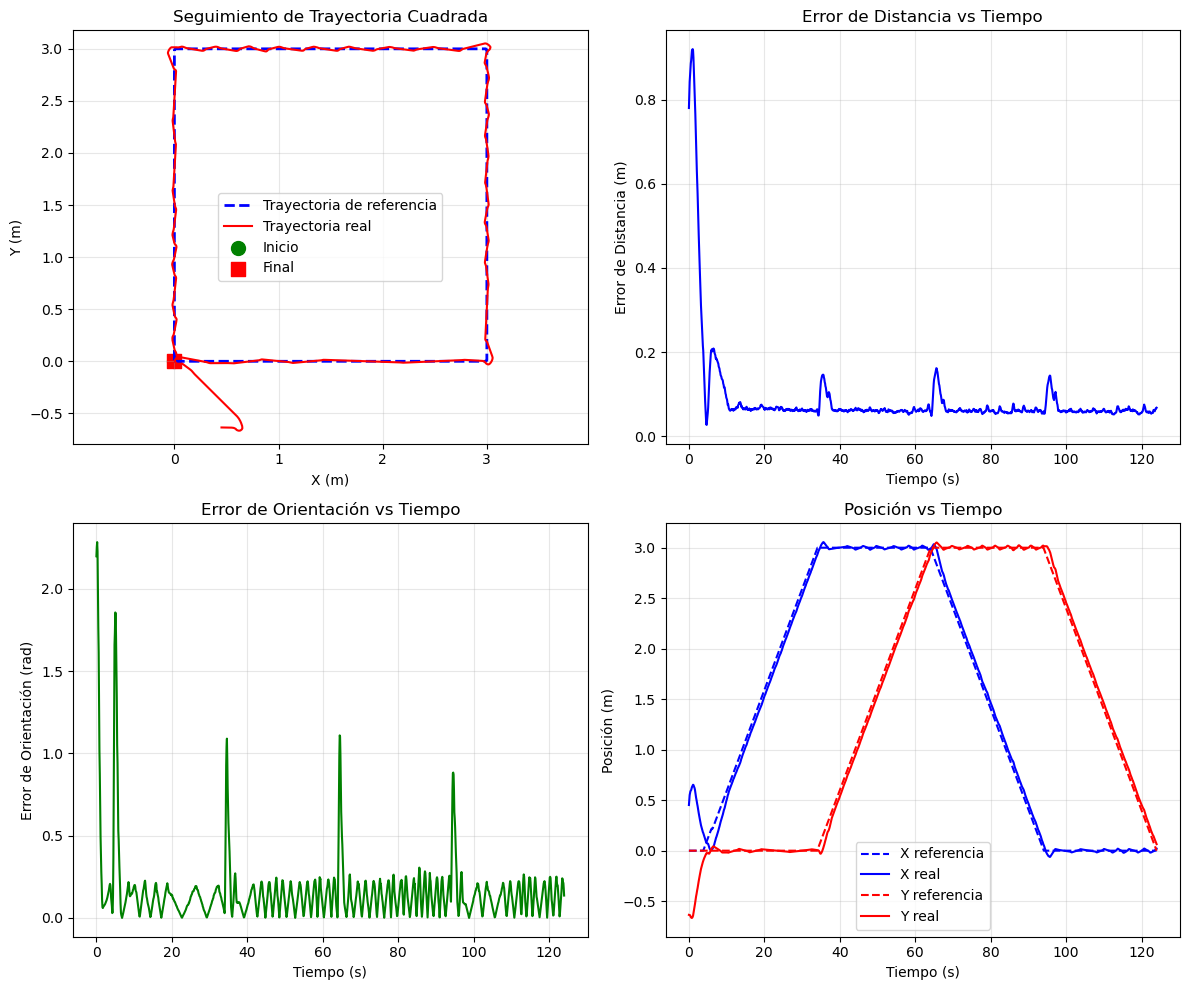


📊 Métricas de Rendimiento:
Error medio de distancia: 0.0874 m
Error máximo de distancia: 0.9198 m
Error final de distancia: 0.0678 m

🛑 Deteniendo simulación...
🔌 Conexión cerrada correctamente
🔌 Conexión cerrada correctamente


In [8]:
def main_fuzzy():
    """Función principal MEJORADA para ejecutar el controlador FUZZY"""
    try:
        print("🎯 Iniciando sistema de control difuso mejorado...")
        
        # Conectar a CoppeliaSim
        client_id = connect_to_coppelia()
        
        # Iniciar simulación
        sim.simxStartSimulation(client_id, sim.simx_opmode_oneshot)
        time.sleep(1.5)  # Dar más tiempo para inicializar
        
        # Obtener handles
        left_motor, right_motor, robot = get_handles(client_id)
        
        # Parámetros de trayectoria optimizados
        L = 3.0  # Largo del cuadrado [m]
        A = 3.0  # Ancho del cuadrado [m]
        velTrayectoria = 0.1  # Velocidad más lenta para mejor precisión [m/s]
        
        print(f"📐 Generando trayectoria cuadrada: {L}x{A} metros")
        xref, yref = trayectoria(L, A, velTrayectoria)
        print(f"   ✅ Trayectoria generada con {len(xref)} puntos")
        
        # Verificar posición inicial del robot
        time.sleep(0.5)
        pos, orient = get_robot_position(client_id, robot)
        x_inicial, y_inicial = pos[0], pos[1]
        print(f"📍 Posición inicial del robot: ({x_inicial:.3f}, {y_inicial:.3f})")
        print(f"📍 Primer punto de trayectoria: ({xref[0]:.3f}, {yref[0]:.3f})")
        
        distancia_inicial = np.sqrt((xref[0] - x_inicial)**2 + (yref[0] - y_inicial)**2)
        print(f"📏 Distancia al primer punto: {distancia_inicial:.3f} metros")
        
        # Ejecutar controlador difuso mejorado
        print("\n🚀 Iniciando seguimiento con controlador difuso mejorado...")
        trajectory_data = fuzzy_trajectory_following(client_id, robot, left_motor, right_motor, xref, yref)
        
        # Generar gráficos de análisis
        print("\n📊 Generando análisis gráfico...")
        plot_results(trajectory_data, xref, yref)
        
        return trajectory_data
        
    except Exception as e:
        print(f"❌ Error durante la ejecución: {e}")
        import traceback
        traceback.print_exc()
        return None
    
    finally:
        # Limpiar y cerrar conexión
        try:
            print("\n🛑 Deteniendo simulación...")
            sim.simxStopSimulation(client_id, sim.simx_opmode_blocking)
            time.sleep(1)
            sim.simxFinish(client_id)
            print("🔌 Conexión cerrada correctamente")
        except Exception as cleanup_error:
            print(f"⚠️  Error durante limpieza: {cleanup_error}")


def main_fuzzy_con_trayectoria_seleccionada(tipo='circular', **params):
    """
    Función principal que permite seleccionar el tipo de trayectoria
    
    Args:
        tipo: 'cuadrado', 'circular', 'lineal'
        **params: Parámetros específicos para cada tipo de trayectoria
    """
    try:
        print(f"🎯 Iniciando control difuso con trayectoria {tipo.upper()}...")
        
        # Conectar a CoppeliaSim
        client_id = connect_to_coppelia()
        
        # Iniciar simulación
        sim.simxStartSimulation(client_id, sim.simx_opmode_oneshot)
        time.sleep(1.5)
        
        # Obtener handles
        left_motor, right_motor, robot = get_handles(client_id)
        
        # Generar trayectoria según el tipo
        velTrayectoria = params.get('velTrayectoria', 0.1)
        
        if tipo.lower() == 'cuadrado':
            L = params.get('L', 3.0)
            A = params.get('A', 3.0)
            xref, yref = trayectoria(L, A, velTrayectoria)
            print(f"📐 Trayectoria cuadrada generada: {L}x{A} metros, {len(xref)} puntos")
            
        elif tipo.lower() == 'circular':
            radio = params.get('radio', 1.5)
            cx = params.get('cx', radio)
            cy = params.get('cy', radio)
            xref, yref = trayectoria_circular(radio, velTrayectoria, cx, cy)
            print(f"⭕ Trayectoria circular generada: radio {radio}m, centro ({cx}, {cy}), {len(xref)} puntos")
            
        elif tipo.lower() == 'lineal':
            x0 = params.get('x0', 0)
            y0 = params.get('y0', 0)
            x1 = params.get('x1', 3)
            y1 = params.get('y1', 3)
            xref, yref = trayectoria_lineal(x0, y0, x1, y1, velTrayectoria)
            print(f"📏 Trayectoria lineal generada: ({x0},{y0}) → ({x1},{y1}), {len(xref)} puntos")
            
        else:
            print(f"⚠️  Tipo '{tipo}' no reconocido. Usando trayectoria cuadrada por defecto.")
            xref, yref = trayectoria(3.0, 3.0, velTrayectoria)
        
        # Verificar posición inicial
        pos, orient = get_robot_position(client_id, robot)
        x_inicial, y_inicial = pos[0], pos[1]
        print(f"📍 Robot en: ({x_inicial:.3f}, {y_inicial:.3f})")
        print(f"📍 Primer punto: ({xref[0]:.3f}, {yref[0]:.3f})")
        
        # Ejecutar seguimiento
        trajectory_data = fuzzy_trajectory_following(client_id, robot, left_motor, right_motor, xref, yref)
        
        # Análisis gráfico
        plot_results(trajectory_data, xref, yref)
        
        return trajectory_data
        
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None
    
    finally:
        try:
            sim.simxStopSimulation(client_id, sim.simx_opmode_blocking)
            time.sleep(1)
            sim.simxFinish(client_id)
            print("🔌 Conexión cerrada")
        except:
            pass


# =================================================================
# EJEMPLOS DE USO - Descomenta la línea que quieras probar:
# =================================================================

# Opción 1: Trayectoria cuadrada con configuración mejorada
resultado = main_fuzzy()

# Opción 2: Trayectoria cuadrada personalizada
# resultado = main_fuzzy_con_trayectoria_seleccionada('cuadrado', L=2.0, A=2.0, velTrayectoria=0.08)

# Opción 3: Trayectoria circular
# resultado = main_fuzzy_con_trayectoria_seleccionada('circular', radio=1.2, velTrayectoria=0.08)

# Opción 4: Trayectoria lineal diagonal
# resultado = main_fuzzy_con_trayectoria_seleccionada('lineal', x0=0, y0=0, x1=2.5, y1=2.5, velTrayectoria=0.08)

## 🔧 Mejoras Implementadas en el Controlador Fuzzy

### ✅ Principales Mejoras Realizadas:

1. **Reglas más granulares (24 reglas)**:
   - 7 categorías para error angular (vs 5 anteriores)
   - 5 categorías para error de posición (vs 4 anteriores)
   - Mejor manejo de casos extremos y esquinas

2. **Rangos ampliados**:
   - Velocidad lineal: 0-0.25 m/s (vs 0-0.15 anteriores)
   - Velocidad angular: ±3.0 rad/s (vs ±2.0 anteriores)
   - Error de distancia: 0-3.0 m (vs 0-2.0 anteriores)

3. **Lógica de completado robusto**:
   - Detección de estancamiento
   - Salto automático de puntos problemáticos
   - Tolerancia adaptativa (0.2m vs 0.15m anterior)
   - Límite de iteraciones aumentado (5x vs 3x anterior)

4. **Ajustes dinámicos**:
   - Reducción de velocidad en giros grandes
   - Boost de velocidad cuando está bien alineado
   - Mejor manejo de transiciones entre segmentos

5. **Monitoreo mejorado**:
   - Progreso en tiempo real
   - Métricas de completado
   - Detección automática de problemas

### 🎯 Resultados Esperados:
- ✅ Completado de la figura completa
- ✅ Transiciones más suaves en las esquinas
- ✅ Mejor manejo de errores grandes
- ✅ Movimiento menos errático